## 1. Import Libraries

In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt

import eda_helper_functions

from sklearn.ensemble import IsolationForest

## 2. Read the Training Data

In [2]:
file_path = r"D:\DataScience\sagemaker-flight-prices-prediction\Data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-12,Kolkata,Banglore,20:00:00,04:40:00,520,1.0,No Info,13941
1,Jet Airways,2019-06-12,Delhi,Cochin,08:00:00,04:25:00,1225,1.0,In-flight meal not included,10577
2,Indigo,2019-06-03,Chennai,Kolkata,07:55:00,10:15:00,140,0.0,No Info,3850
3,Jet Airways,2019-03-03,Delhi,Cochin,09:00:00,18:50:00,590,1.0,In-flight meal not included,15400
4,Jet Airways,2019-05-21,Delhi,Cochin,14:00:00,19:00:00,300,1.0,No Info,16079
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-04-09,Delhi,Cochin,06:00:00,13:20:00,440,1.0,No Info,8323
636,Indigo,2019-04-12,Kolkata,Banglore,14:25:00,16:55:00,150,0.0,No Info,5224
637,Jet Airways,2019-03-18,Banglore,New Delhi,08:55:00,15:15:00,380,1.0,No Info,12284
638,Multiple Carriers,2019-05-21,Delhi,Cochin,10:35:00,19:00:00,505,1.0,No Info,9103


### 2.1 Fixing Data Types

In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
	col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
	for col in ["date_of_journey", "dep_time", "arrival_time"]
})

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

In [5]:
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-12,Kolkata,Banglore,2024-06-13 20:00:00,2024-06-13 04:40:00,520,1.0,No Info,13941
1,Jet Airways,2019-06-12,Delhi,Cochin,2024-06-13 08:00:00,2024-06-13 04:25:00,1225,1.0,In-flight meal not included,10577
2,Indigo,2019-06-03,Chennai,Kolkata,2024-06-13 07:55:00,2024-06-13 10:15:00,140,0.0,No Info,3850
3,Jet Airways,2019-03-03,Delhi,Cochin,2024-06-13 09:00:00,2024-06-13 18:50:00,590,1.0,In-flight meal not included,15400
4,Jet Airways,2019-05-21,Delhi,Cochin,2024-06-13 14:00:00,2024-06-13 19:00:00,300,1.0,No Info,16079
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-04-09,Delhi,Cochin,2024-06-13 06:00:00,2024-06-13 13:20:00,440,1.0,No Info,8323
636,Indigo,2019-04-12,Kolkata,Banglore,2024-06-13 14:25:00,2024-06-13 16:55:00,150,0.0,No Info,5224
637,Jet Airways,2019-03-18,Banglore,New Delhi,2024-06-13 08:55:00,2024-06-13 15:15:00,380,1.0,No Info,12284
638,Multiple Carriers,2019-05-21,Delhi,Cochin,2024-06-13 10:35:00,2024-06-13 19:00:00,505,1.0,No Info,9103


## 3. High-level Summary of Data

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [7]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,626.851562,0.837500,8992.503125
std,486.986085,0.672626,4238.963050
min,75.000000,0.000000,2175.000000
25%,175.000000,0.000000,5403.000000
50%,502.500000,1.000000,8363.000000
75%,895.000000,1.000000,12209.750000
max,2295.000000,4.000000,31825.000000


In [8]:
(
	train
	.assign(total_stops=train["total_stops"].astype(object))
	.describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,5.0,6
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,224,285,285,348.0,514


## 4. High-level analysis of Missing Values

In [9]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


## 5. High-level analysis of Outliers

In [10]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [11]:
(
	train
	.assign(outlier=forest.fit_predict(
		train
		.drop(columns="price")
		.select_dtypes(include="number")
	))
	.query("outlier == -1")
	# .duration
	# .describe()
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,outlier
1,Jet Airways,2019-06-12,Delhi,Cochin,2024-06-13 08:00:00,2024-06-13 04:25:00,1225,1.0,In-flight meal not included,10577,-1
2,Indigo,2019-06-03,Chennai,Kolkata,2024-06-13 07:55:00,2024-06-13 10:15:00,140,0.0,No Info,3850,-1
5,Indigo,2019-05-27,Delhi,Cochin,2024-06-13 21:05:00,2024-06-13 00:20:00,195,0.0,No Info,5601,-1
6,Indigo,2019-06-09,Chennai,Kolkata,2024-06-13 05:15:00,2024-06-13 07:40:00,145,0.0,No Info,3540,-1
8,Indigo,2019-06-01,Delhi,Cochin,2024-06-13 07:35:00,2024-06-13 12:10:00,275,1.0,No Info,5054,-1
...,...,...,...,...,...,...,...,...,...,...,...
626,Indigo,2019-05-03,Chennai,Kolkata,2024-06-13 19:35:00,2024-06-13 21:55:00,140,0.0,No Info,3597,-1
629,Indigo,2019-05-27,Chennai,Kolkata,2024-06-13 22:05:00,2024-06-13 00:25:00,140,0.0,No Info,5277,-1
630,Jet Airways,2019-04-01,Delhi,Cochin,2024-06-13 16:00:00,2024-06-13 12:35:00,1235,1.0,In-flight meal not included,5406,-1
632,Air India,2019-06-12,Kolkata,Banglore,2024-06-13 20:30:00,2024-06-13 20:25:00,1435,1.0,No Info,10203,-1


## 6. Pair Plots

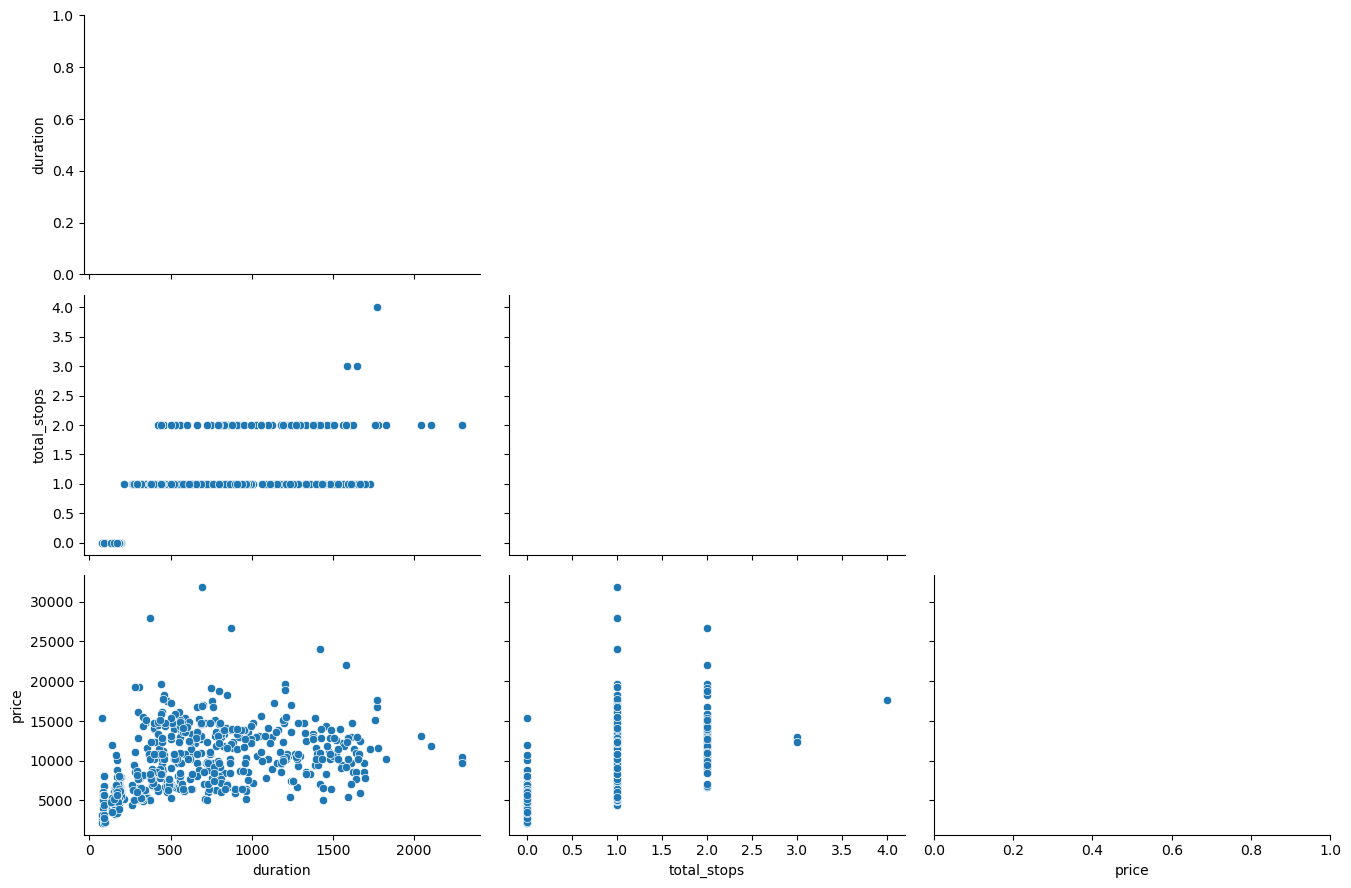

In [12]:
eda_helper_functions.pair_plots(train)

## 7. Correlation Analysis

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


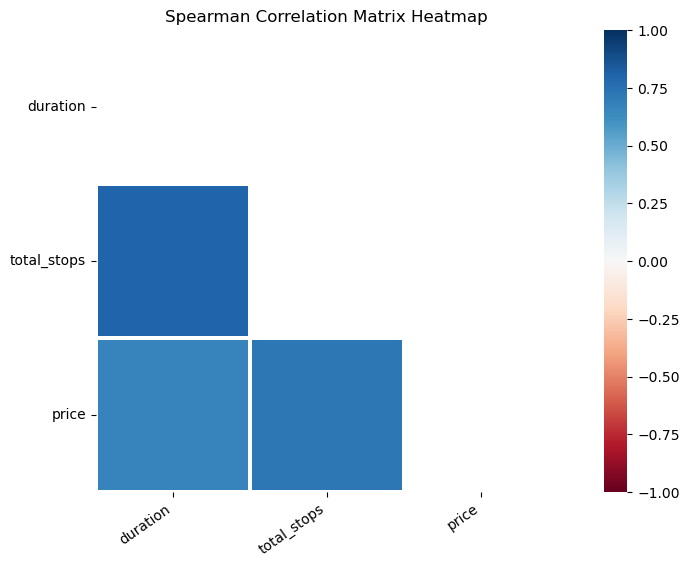

In [13]:
eda_helper_functions.correlation_heatmap(train)

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


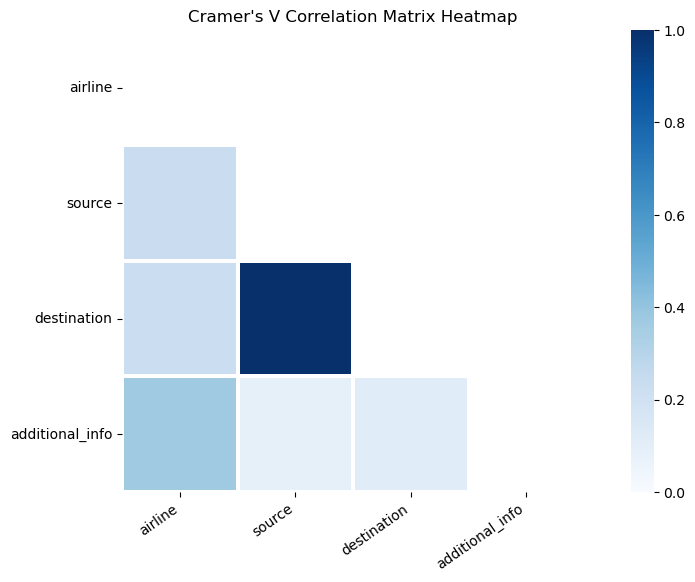

In [14]:
eda_helper_functions.cramersV_heatmap(train)

## 8. Detailed Analysis

In [15]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airline

In [16]:
train.airline

0            Jet Airways
1            Jet Airways
2                 Indigo
3            Jet Airways
4            Jet Airways
             ...        
635    Multiple Carriers
636               Indigo
637          Jet Airways
638    Multiple Carriers
639               Indigo
Name: airline, Length: 640, dtype: object

In [17]:
eda_helper_functions.cat_summary(train, "airline")

0            Jet Airways
1            Jet Airways
2                 Indigo
3            Jet Airways
4            Jet Airways
             ...        
635    Multiple Carriers
636               Indigo
637          Jet Airways
638    Multiple Carriers
639               Indigo
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,224


,count,percentage
category,,
Jet Airways,224,0.350000
Indigo,139,0.217188
Air India,116,0.181250
Multiple Carriers,61,0.095312
Spicejet,37,0.057813
Vistara,33,0.051562
Air Asia,17,0.026562
Goair,13,0.020313


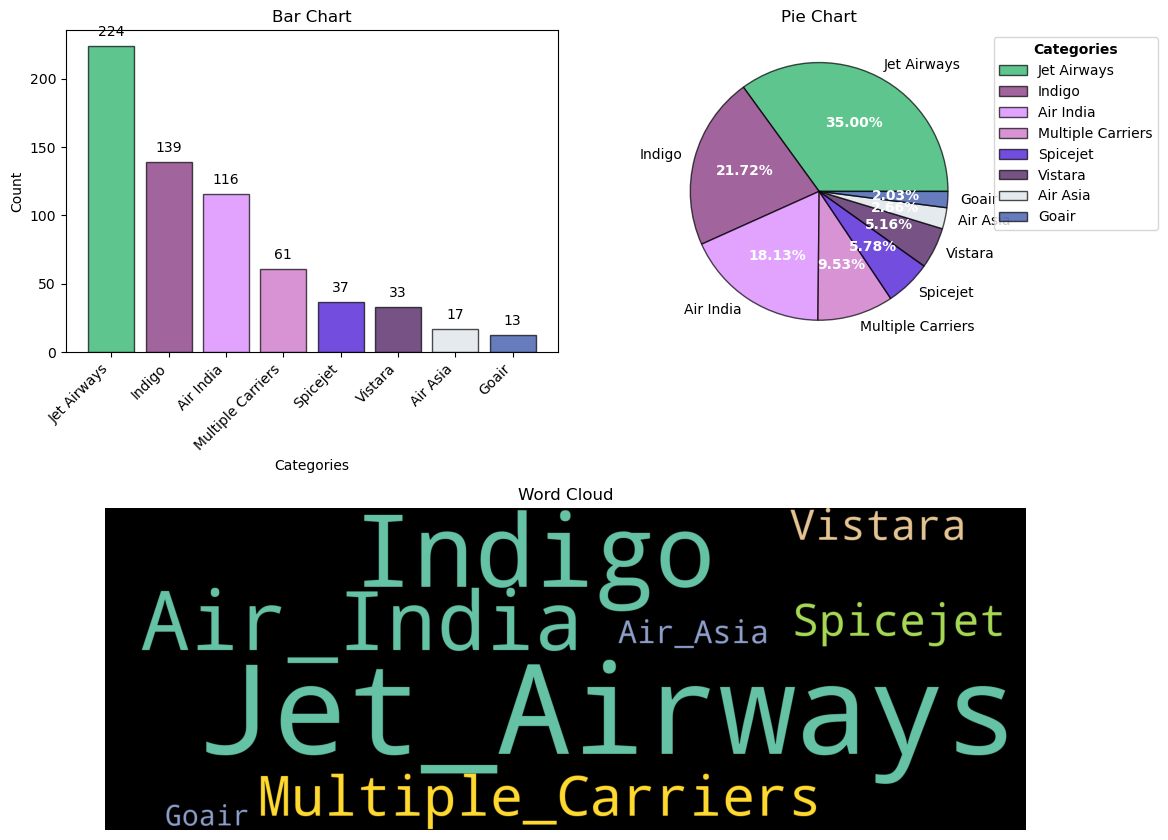

In [18]:
eda_helper_functions.cat_univar_plots(train, "airline")

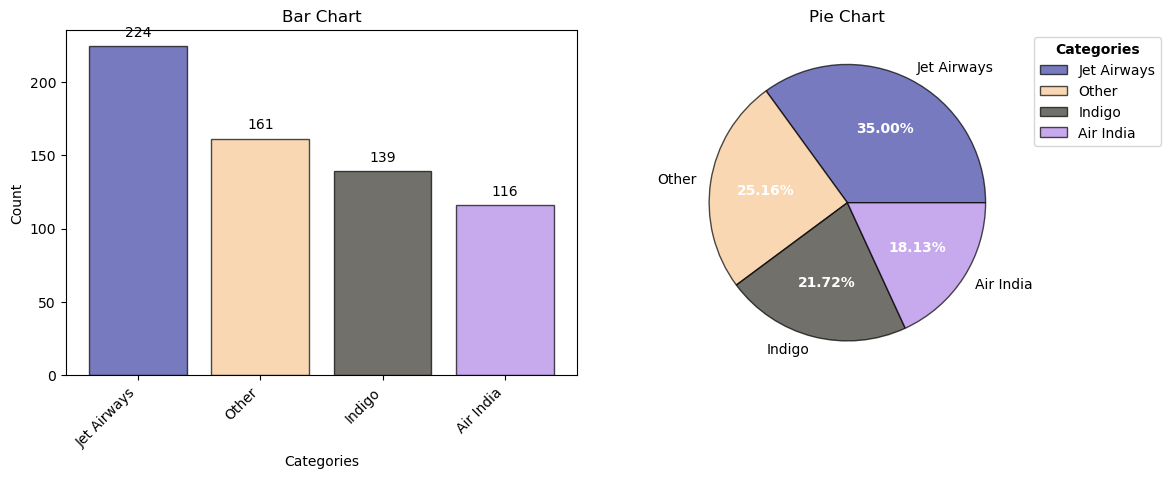

In [19]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=3)

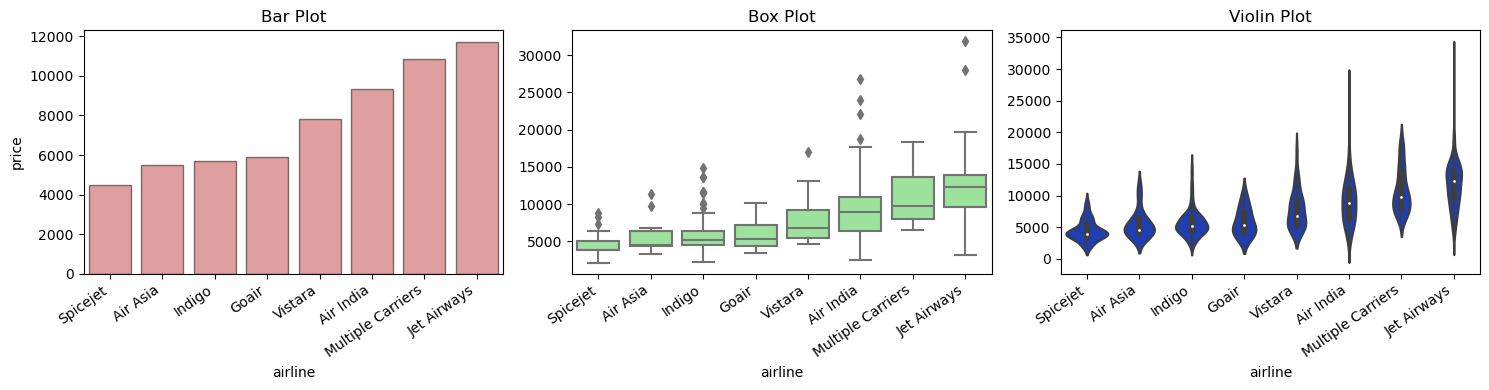

In [20]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

In [21]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 59.41482827425773
- p-value              : 2.190556429816689e-65
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 304.2639571490706
- p-value              : 7.430952930240123e-62
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


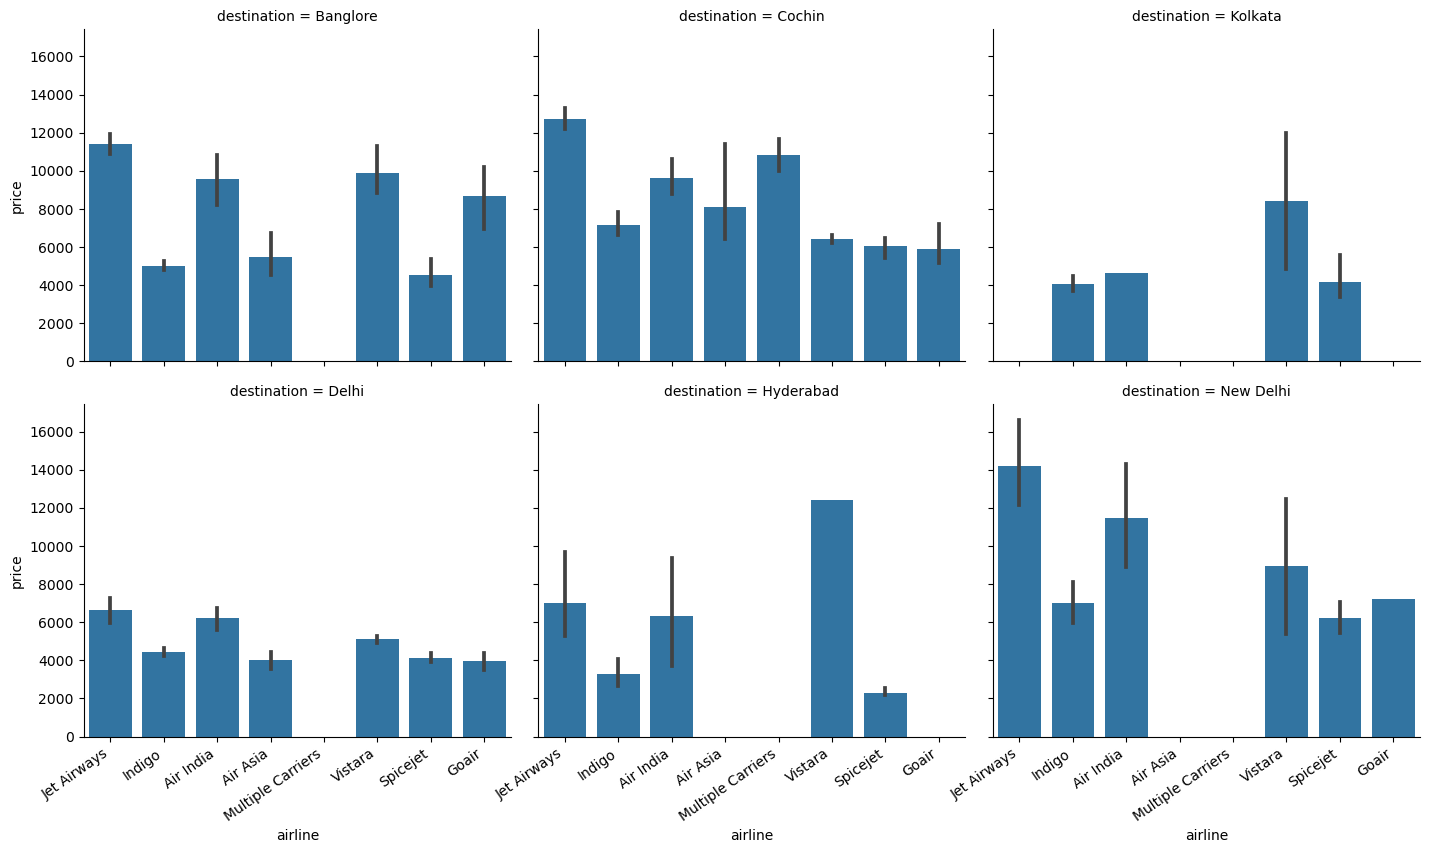

In [22]:
airline_grid = sns.FacetGrid(
	data=train,
	col="destination",
	col_wrap=3,
	height=4,
	aspect=1.2,
	sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
	eda_helper_functions.rotate_xlabels(ax)

### 8.2 date_of_journey

In [23]:
train.date_of_journey

0     2019-05-12
1     2019-06-12
2     2019-06-03
3     2019-03-03
4     2019-05-21
         ...    
635   2019-04-09
636   2019-04-12
637   2019-03-18
638   2019-05-21
639   2019-03-15
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

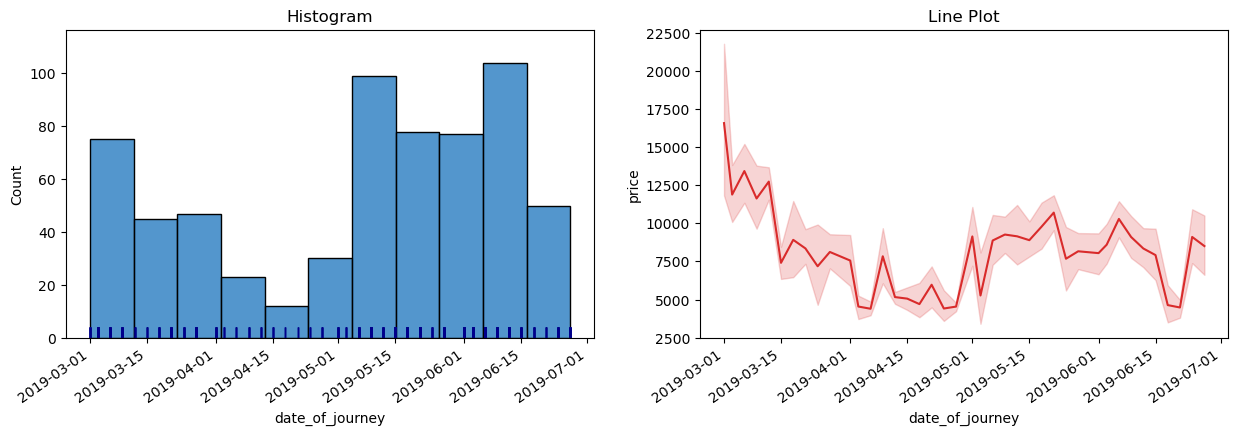

In [24]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

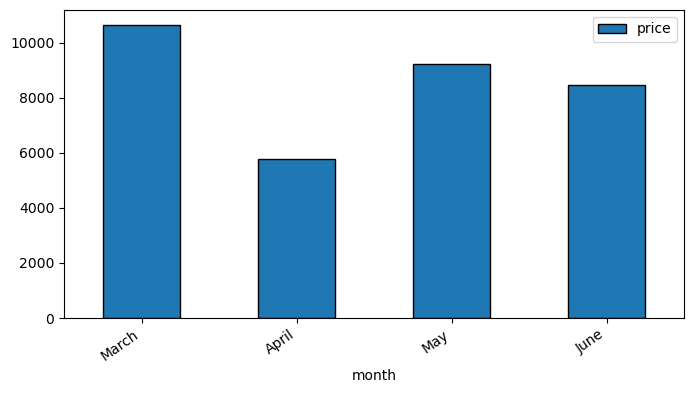

In [25]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

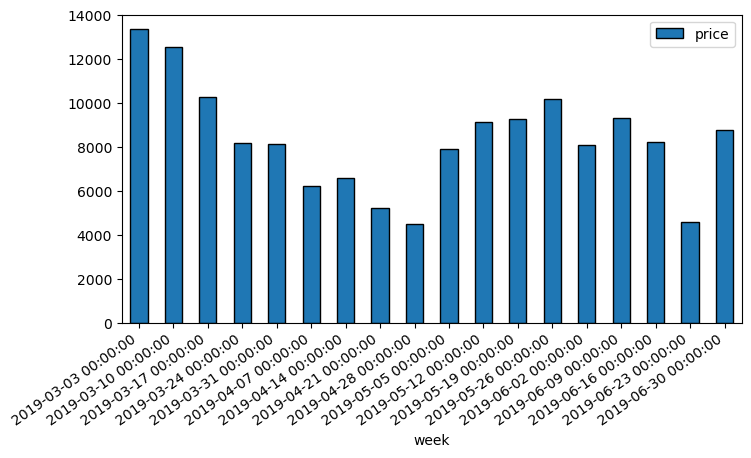

In [26]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

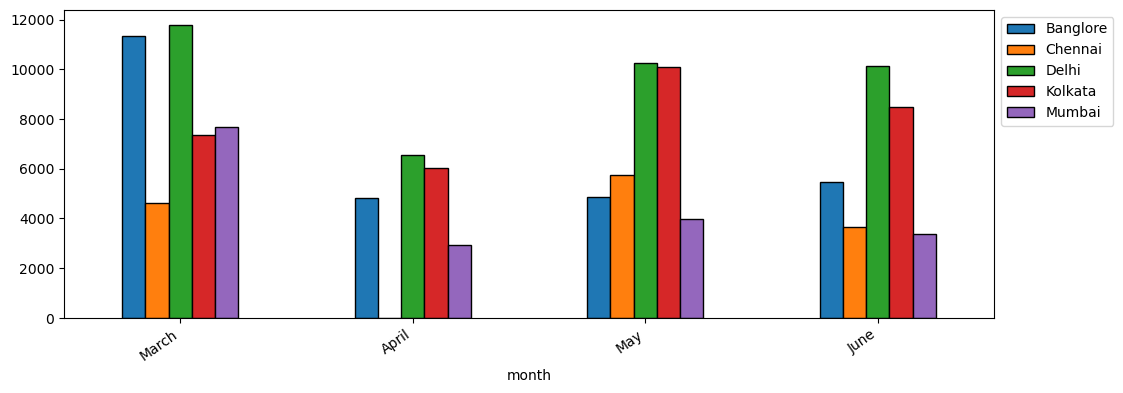

In [27]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### 8.3 dep_time

In [28]:
train.dep_time

0     2024-06-13 20:00:00
1     2024-06-13 08:00:00
2     2024-06-13 07:55:00
3     2024-06-13 09:00:00
4     2024-06-13 14:00:00
              ...        
635   2024-06-13 06:00:00
636   2024-06-13 14:25:00
637   2024-06-13 08:55:00
638   2024-06-13 10:35:00
639   2024-06-13 04:00:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

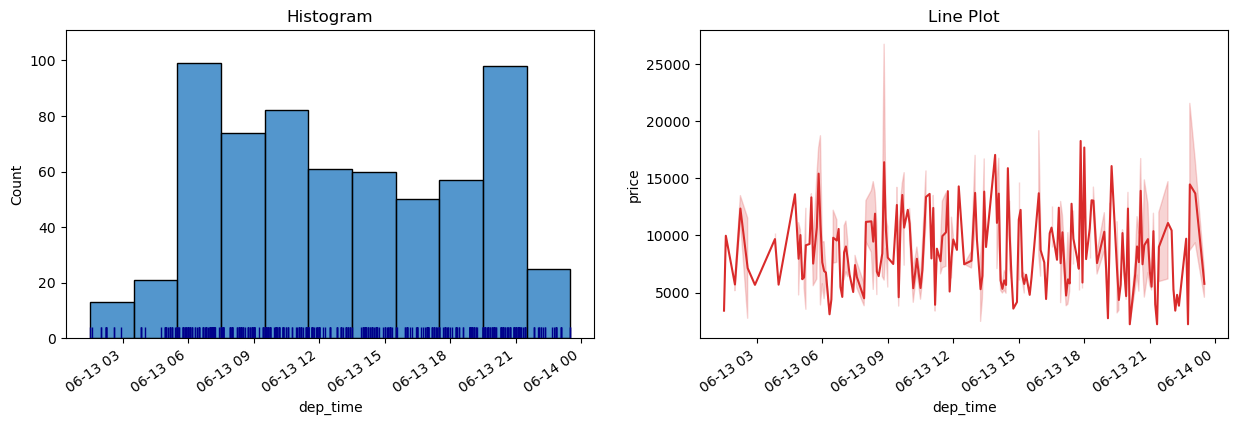

In [29]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

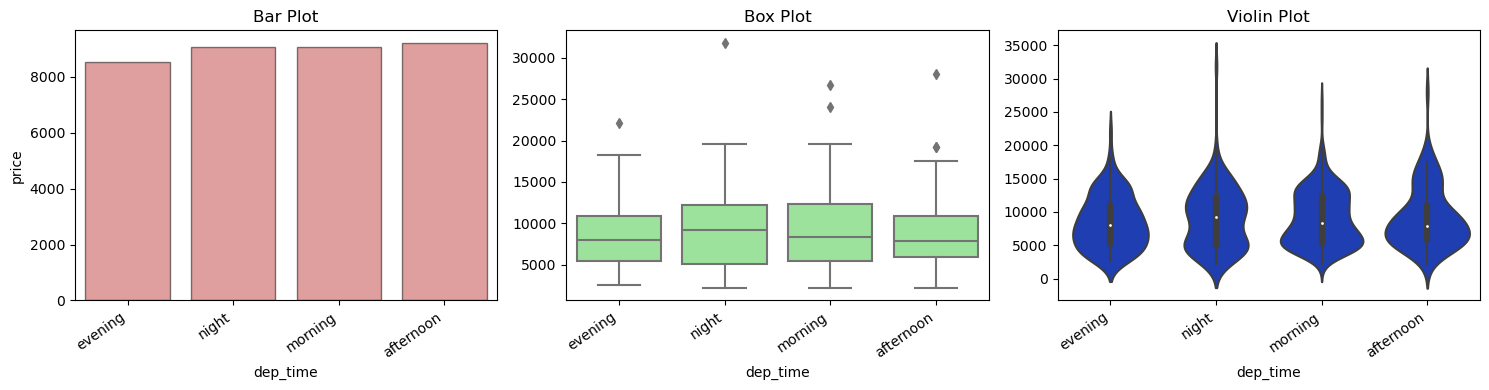

In [30]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### 8.4 duration

In [31]:
train.duration

0       520
1      1225
2       140
3       590
4       300
       ... 
635     440
636     150
637     380
638     505
639     170
Name: duration, Length: 640, dtype: int64

In [32]:
eda_helper_functions.num_summary(train, "duration")

0       520
1      1225
2       140
3       590
4       300
       ... 
635     440
636     150
637     380
638     505
639     170
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,75.00
5,90.00
10,150.00
25,175.00
50,502.50
75,895.00
90,1420.00
95,1585.50
99,1778.05


,value
mean,626.851562
trimmed mean (5%),594.253472
trimmed mean (10%),566.523438
median,502.500000


,value
var,237155.447415
std,486.986085
IQR,720.000000
mad,332.500000
coef_variance,0.776876


,value
skewness,0.903745
kurtosis,-0.023588


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 7.297360706755101e-21
Test Statistic       : 0.8909792304039001
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 22.284226558791374
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [33]:
train.duration.quantile([0.25, 0.5, 0.75])

0.25    175.0
0.50    502.5
0.75    895.0
Name: duration, dtype: float64

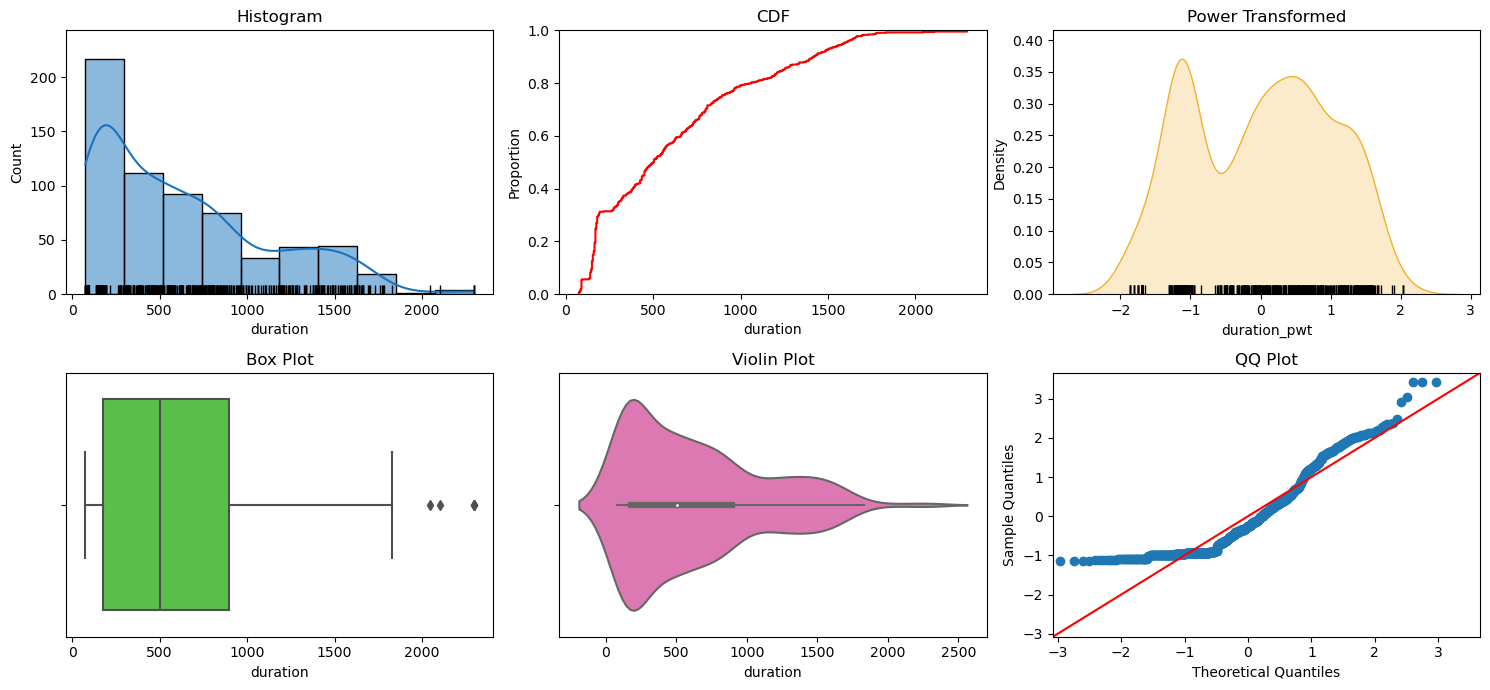

In [34]:
eda_helper_functions.num_univar_plots(train, "duration")

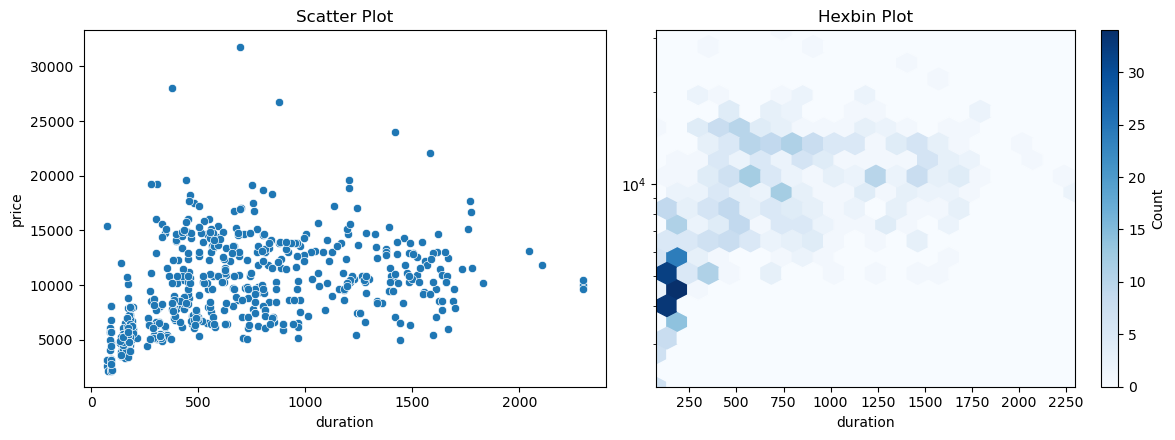

In [35]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [36]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.48666985619195136
- p-value              : 2.3065940326276332e-39
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6648960126045351
- p-value              : 6.769142938668072e-83
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


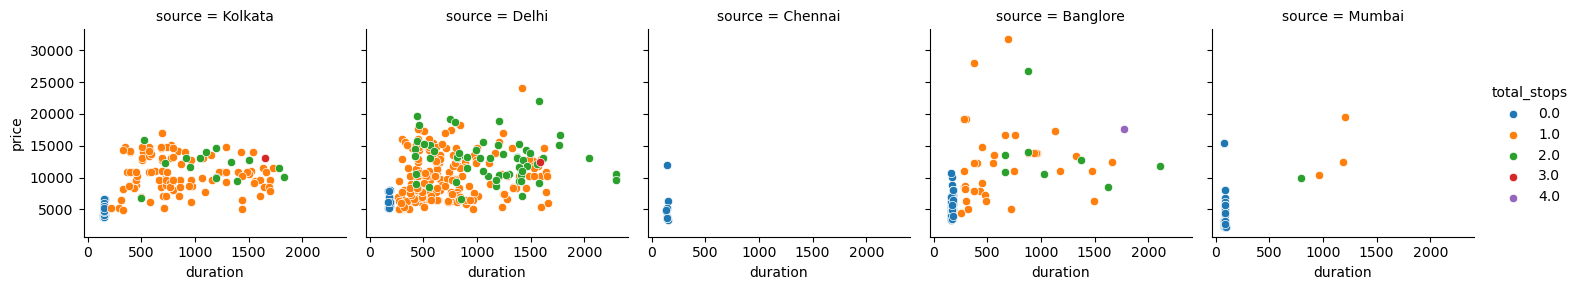

In [37]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

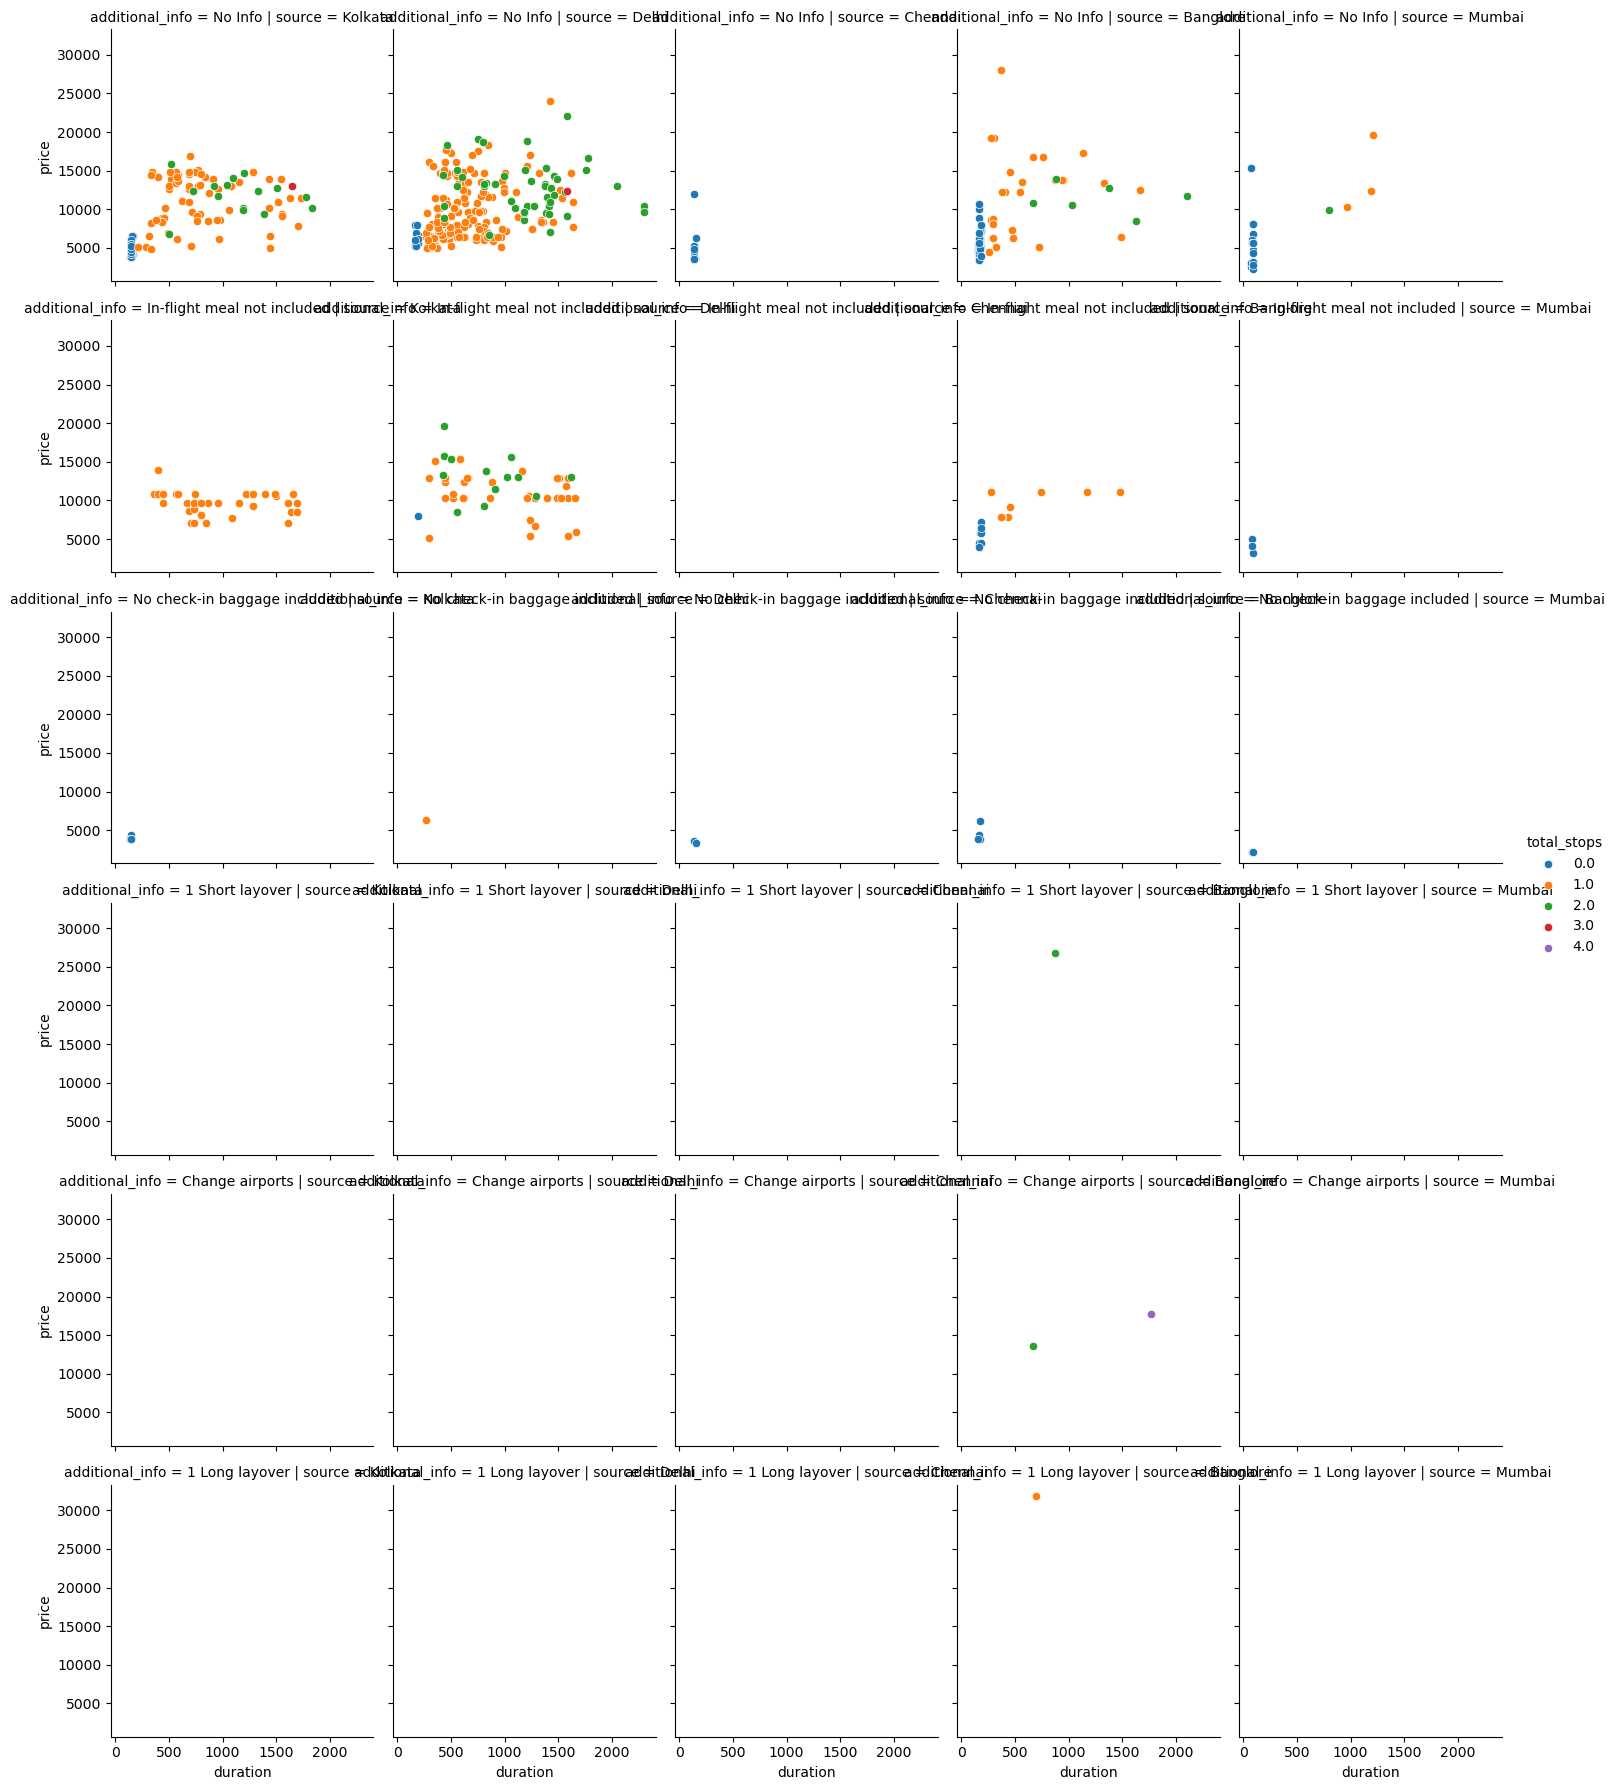

In [38]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [39]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -905.0
Upper Limit : 1975.0


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
480,Jet Airways,2019-03-21,Delhi,Cochin,2024-06-13 18:20:00,2024-06-13 04:25:00,2045,2.0,No Info,13082
193,Air India,2019-03-03,Banglore,New Delhi,2024-06-13 11:05:00,2024-06-13 22:10:00,2105,2.0,No Info,11791
45,Air India,2019-06-09,Delhi,Cochin,2024-06-13 05:00:00,2024-06-13 19:15:00,2295,2.0,No Info,9968
279,Air India,2019-05-15,Delhi,Cochin,2024-06-13 05:00:00,2024-06-13 19:15:00,2295,2.0,No Info,10493
470,Air India,2019-06-06,Delhi,Cochin,2024-06-13 05:00:00,2024-06-13 19:15:00,2295,2.0,No Info,9653


### 8.5 additional_info

In [40]:
eda_helper_functions.cat_summary(train, "additional_info")

0                          No Info
1      In-flight meal not included
2                          No Info
3      In-flight meal not included
4                          No Info
                  ...             
635                        No Info
636                        No Info
637                        No Info
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

Data Type      : object
Cardinality    : 6 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,6
top,No Info
freq,514


,count,percentage
category,,
No Info,514,0.803125
In-flight meal not included,108,0.168750
No check-in baggage included,14,0.021875
Change airports,2,0.003125
1 Short layover,1,0.001563
1 Long layover,1,0.001563


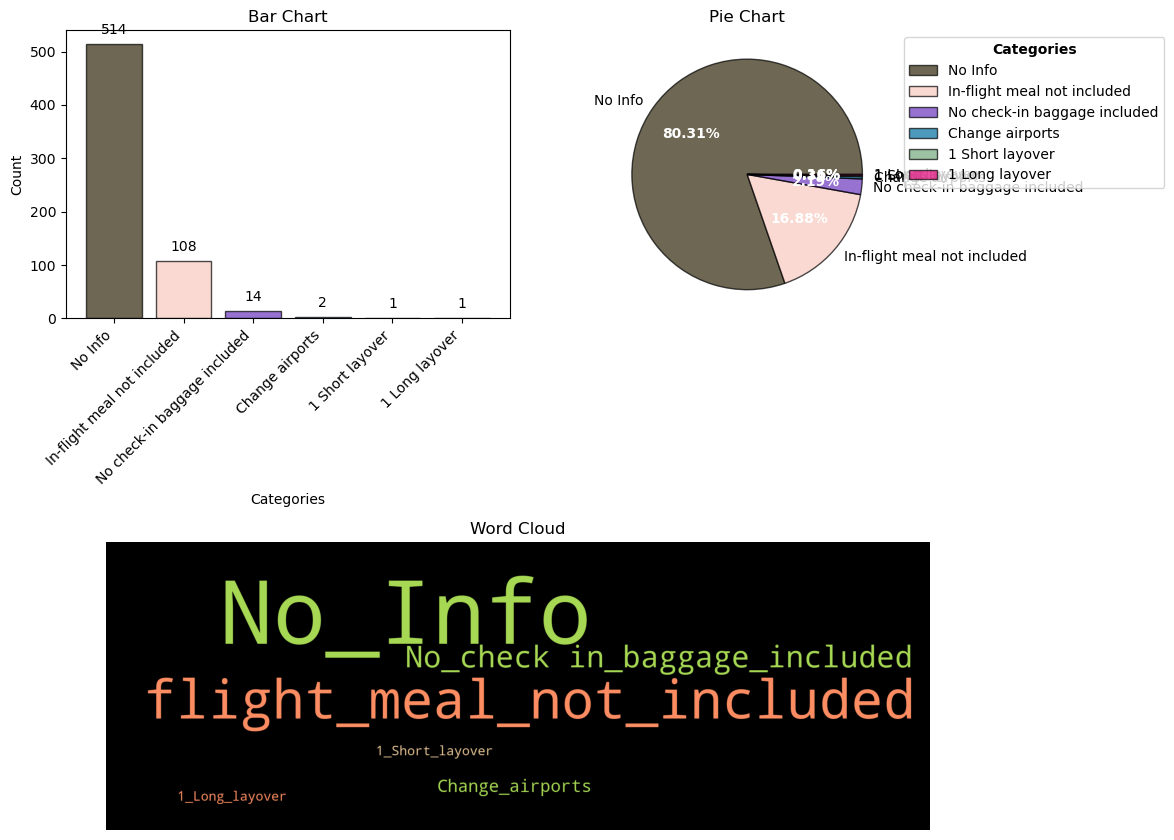

In [41]:
eda_helper_functions.cat_univar_plots(train, "additional_info")

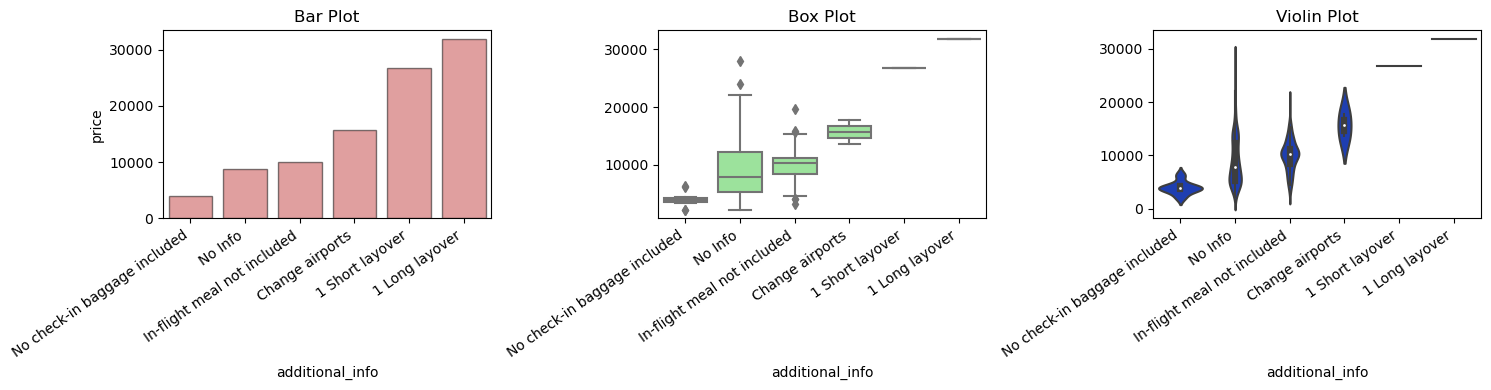

In [42]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")

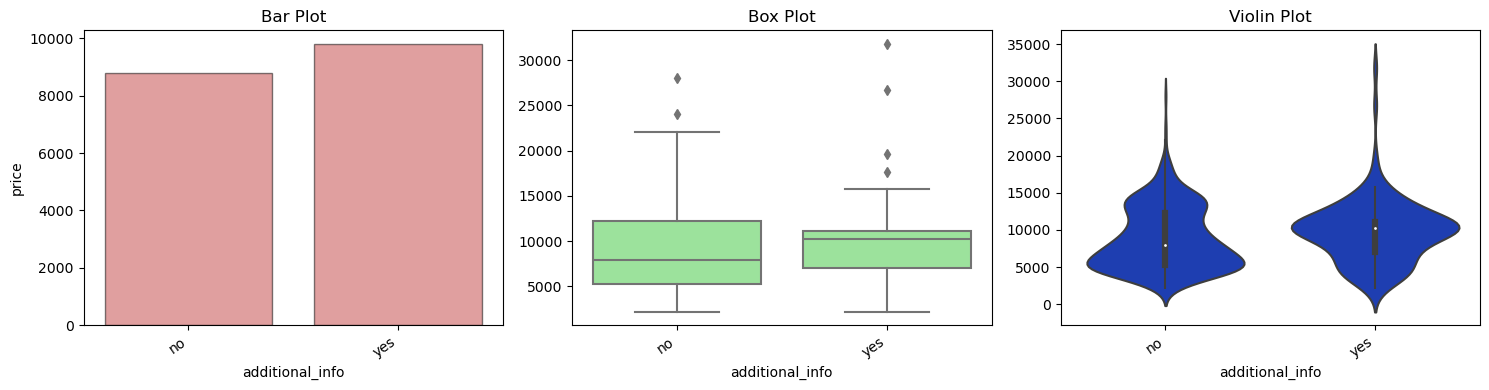

In [43]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)

- `additional_info` has severely rare categories
- Converted it into a binary feature for further analysis

## 9. Automated EDA

In [45]:
from ydata_profiling import ProfileReport

In [46]:
report = ProfileReport(train)

In [47]:
report.to_file(output_file="output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]